In [18]:
from __future__ import division
from __future__ import print_function
import os
import sys
from time import time
import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import matplotlib.font_manager
import pandas as pd
import seaborn as sns
from scipy.spatial.distance import pdist
from math import ceil
from pandas import Series
# Import all models

from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA

import warnings
warnings.filterwarnings("ignore")

# **和wine数据库一样，同样以一个csv为例来分析**

In [19]:
abalone_df=pd.read_csv("Outlier_abalone/benchmarks/abalone_benchmark_0001.csv",encoding="utf-8")
abalone_df.head()

,point.id,motherset,origin,original.label,diff.score,ground.truth,V1,V2,V3,V4,V5,V6,V7
0,abalone_point_1584,abalone,regression,7,0.153312,nominal,-0.116511,-0.129799,-0.227518,-0.461352,-0.353066,-0.342963,-0.551935
1,abalone_point_0315,abalone,regression,23,0.202253,anomaly,0.882716,0.777094,0.848341,0.960988,0.333986,1.039157,1.588828
2,abalone_point_1779,abalone,regression,8,0.562701,nominal,-0.283048,-0.532863,0.489721,0.103505,-0.048961,0.313886,0.313709
3,abalone_point_1926,abalone,regression,11,0.209155,anomaly,0.716178,0.625945,0.609261,0.713225,0.930932,0.893190,0.396322
4,abalone_point_0588,abalone,regression,13,0.163268,anomaly,0.216565,0.021350,0.131102,-0.000494,-0.224666,0.090375,0.080237


In [20]:
gt=abalone_df["ground.truth"]########提取ground.truth,计算正常点和异常点的数量
count = gt.value_counts()
gt=abalone_df[["ground.truth"]]
print("该数据集异常点和正常点的数量\n"+str(count))

该数据集异常点和正常点的数量
nominal    975
anomaly    913
Name: ground.truth, dtype: int64


In [21]:
abalone_data1=abalone_df.iloc[:,[4]]
abalone_data2=abalone_df.iloc[:,6:12]
abalone_data=abalone_data1.join(abalone_data2)
abalone_data.head()

,diff.score,V1,V2,V3,V4,V5,V6
0,0.153312,-0.116511,-0.129799,-0.227518,-0.461352,-0.353066,-0.342963
1,0.202253,0.882716,0.777094,0.848341,0.960988,0.333986,1.039157
2,0.562701,-0.283048,-0.532863,0.489721,0.103505,-0.048961,0.313886
3,0.209155,0.716178,0.625945,0.609261,0.713225,0.930932,0.893190
4,0.163268,0.216565,0.021350,0.131102,-0.000494,-0.224666,0.090375


# 将ground.truth中的正常值设为0，异常值设为1

In [22]:
gt.loc[gt["ground.truth"]=="nominal"]=0
gt.loc[gt["ground.truth"]=="anomaly"]=1


In [23]:
abalone_data=abalone_data.values ##矩阵化
print(abalone_data)

[[ 0.15331235 -0.11651062 -0.12979919 ... -0.46135242 -0.35306563
  -0.34296278]
 [ 0.20225298  0.88271571  0.77709441 ...  0.96098775  0.33398597
   1.03915679]
 [ 0.5627006  -0.28304834 -0.53286302 ...  0.10350526 -0.04896082
   0.31388612]
 ...
 [ 0.54783519 -0.44958606 -0.53286302 ... -0.79068279 -0.93199108
  -0.58471967]
 [ 0.19341441  0.79944685  1.33130717 ...  0.63267697  0.6313329
   0.57388881]
 [ 0.23913479 -0.40795163 -0.53286302 ... -0.69789931 -0.64815993
  -0.63945708]]


In [24]:
random_state = np.random.RandomState(10)
outliers_fraction=0.45

#定义用于检测异常值的算法
classifiers = {
    'Cluster-based Local Outlier Factor (CBLOF)':
        CBLOF(contamination=outliers_fraction,
              check_estimator=False, random_state=random_state),
        'Feature Bagging':
        FeatureBagging(LOF(n_neighbors=35),
                       contamination=outliers_fraction,
                       random_state=random_state),
    'Histogram-base Outlier Detection (HBOS)': HBOS(
        contamination=outliers_fraction),
    'Isolation Forest': IForest(contamination=outliers_fraction,
                                random_state=random_state),
    'K Nearest Neighbors (KNN)': KNN(
        contamination=outliers_fraction),
    'Average KNN': KNN(method='mean',
                       contamination=outliers_fraction),
    'Local Outlier Factor (LOF)':
        LOF(n_neighbors=35, contamination=outliers_fraction),
    'Minimum Covariance Determinant (MCD)': MCD(
        contamination=outliers_fraction, random_state=random_state),
    'One-class SVM (OCSVM)': OCSVM(contamination=outliers_fraction),
    'Principal Component Analysis (PCA)': PCA(
        contamination=outliers_fraction, random_state=random_state),
 
}

In [25]:
for i, clf in enumerate(classifiers.keys()):
    print('Model', i + 1, clf)

Model 1 Cluster-based Local Outlier Factor (CBLOF)
Model 2 Feature Bagging
Model 3 Histogram-base Outlier Detection (HBOS)
Model 4 Isolation Forest
Model 5 K Nearest Neighbors (KNN)
Model 6 Average KNN
Model 7 Local Outlier Factor (LOF)
Model 8 Minimum Covariance Determinant (MCD)
Model 9 One-class SVM (OCSVM)
Model 10 Principal Component Analysis (PCA)


**和wine数据库类似，分划分训练测试集和不划分两种情况，分别调用CBLOF，FB，HBOS，IF，AVG_KNN，Loc KNN，LOF，MCD，OCSVM，PCA算法对该csv进行异常点检测，检测的结果通过ROC曲线和AUC值来评价**

1 fitting Cluster-based Local Outlier Factor (CBLOF)
内点:1038  外点:850
总897
AUC值为0.5234920095205712


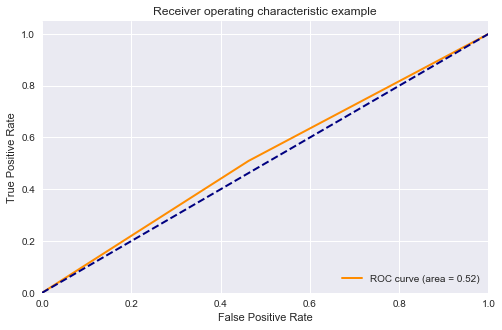

2 fitting Feature Bagging
内点:1072  外点:816
总869
AUC值为0.538200541410594


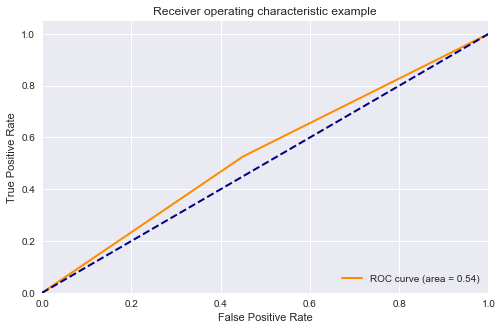

3 fitting Histogram-base Outlier Detection (HBOS)
内点:1041  外点:847
总1152
AUC值为0.38694970211868296


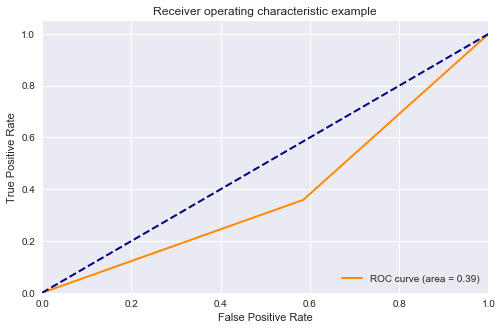

4 fitting Isolation Forest
内点:1038  外点:850
总1133
AUC值为0.39724016774339793


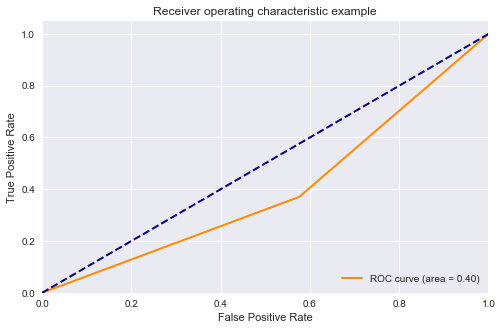

5 fitting K Nearest Neighbors (KNN)
内点:1125  外点:763
总692
AUC值为0.6353004223095966


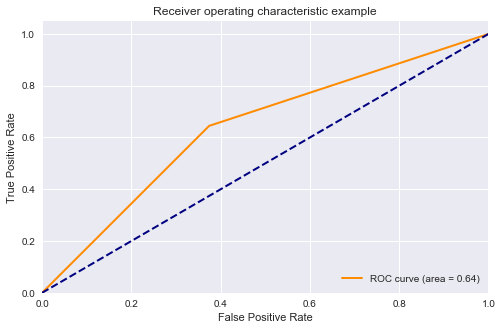

6 fitting Average KNN
内点:1426  外点:462
总733
AUC值为0.639828964864028


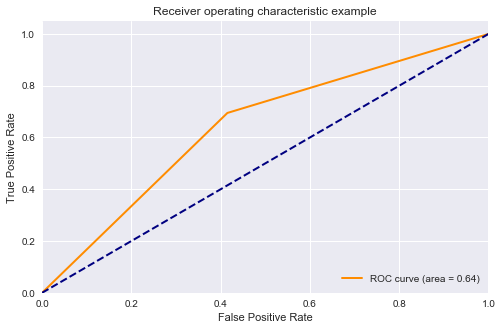

7 fitting Local Outlier Factor (LOF)
内点:1065  外点:823
总850
AUC值为0.5484800255563352


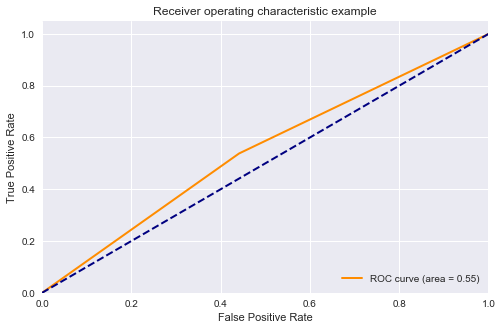

8 fitting Minimum Covariance Determinant (MCD)
内点:1038  外点:850
总577
AUC值为0.6946809475235182


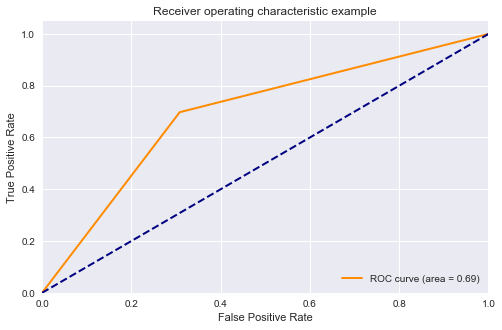

9 fitting One-class SVM (OCSVM)
内点:1038  外点:850
总931
AUC值为0.5053031848577582


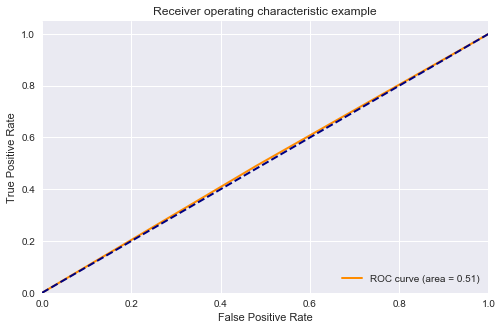

10 fitting Principal Component Analysis (PCA)
内点:1038  外点:850
总1029
AUC值为0.45287657259435565


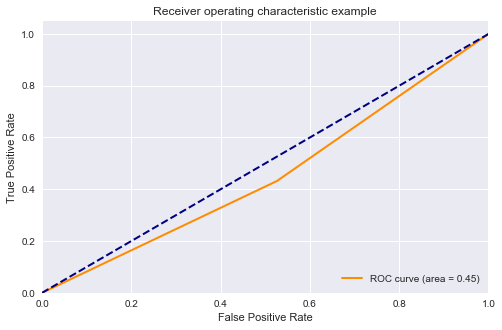

In [26]:
##########################################
###########不划分训练集和测试集###########
##########################################
from sklearn.metrics import roc_curve, auc
algorithm_list=pd.DataFrame(columns=['CBLOF' ,'FB','HBOS','IF','AVG_KNN','Loc KNN','LOF','MCD','OCSVM','PCA'])

temp=0
df_array=[]

for i, (clf_name, clf) in enumerate(classifiers.items()):
    print(i + 1, 'fitting', clf_name)
    # fit the data and tag outliers
    clf.fit(abalone_data)
    scores_pred = clf.decision_function(abalone_data) * -1
    y_pred = clf.predict(abalone_data)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    threshold = percentile(scores_pred, 100 * outliers_fraction)
    print("内点:"+str(n_inliers)+"  "+"外点:"+str(n_outliers))

    n_errors = (y_pred.flatten() != gt.values.flatten()).sum()
    # plot the levels lines and the points
    print("总"+str(n_errors))
    fpr, tpr, threshold = roc_curve(y_pred, gt.values.flatten())  ###计算真正率和假正率
    roc_auc = auc(fpr, tpr)  ###计算auc的值
    print("AUC值为"+str(roc_auc))
    df_array.append(roc_auc)

    lw = 2
    plt.figure(figsize=(8, 5))
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)  ###假正率为横坐标，真正率为纵坐标做曲线
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

algorithm_list.loc[temp]=df_array

In [27]:
#以列表的形式展出
algorithm_list.index=["abalone_benchmarks_0001.csv"]
algorithm_list.head()

,CBLOF,FB,HBOS,IF,AVG_KNN,Loc KNN,LOF,MCD,OCSVM,PCA
abalone_benchmarks_0001.csv,0.523492,0.538201,0.38695,0.39724,0.6353,0.639829,0.54848,0.694681,0.505303,0.452877


**各算法在0001.csv上的性能如上，可以看到，在训练数据为整体的基础上，基于KNN的两种算法AUC值可以上到0.6以上，而MCD算法AUC值接近0.70，为这些算法中最优，但HBOS，IF算法性能不行，基本属于瞎猜，其余算法的AUC值都在0.4-0.6之间，性能一般，这个数据库上各种算法性能的差异更明显，有明显的的算法优劣度区分。**

1 fitting Cluster-based Local Outlier Factor (CBLOF)
内点:212  外点:164
总184
AUC值为0.5066728025770824


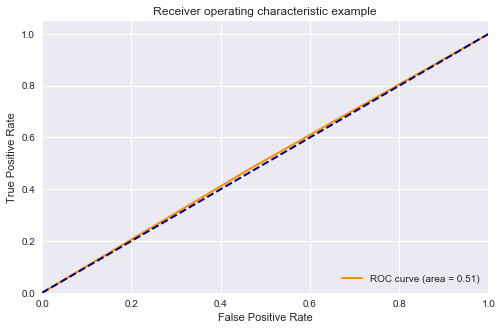

2 fitting Feature Bagging
内点:213  外点:163
总185
AUC值为0.5038019528212218


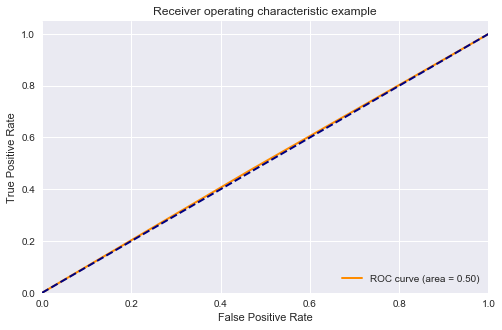

3 fitting Histogram-base Outlier Detection (HBOS)
内点:210  外点:166
总206
AUC值为0.4476764199655766


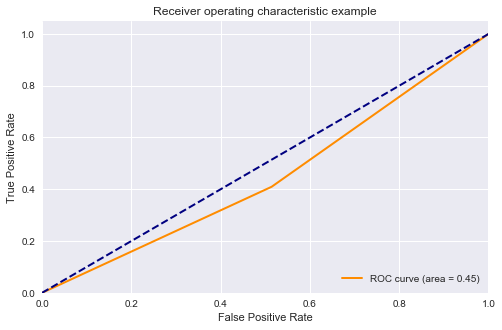

4 fitting Isolation Forest
内点:198  外点:178
总194
AUC值为0.48229485869935307


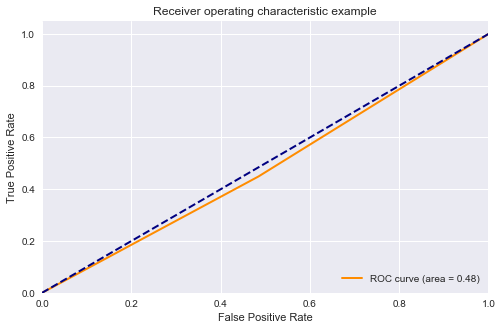

5 fitting K Nearest Neighbors (KNN)
内点:221  外点:155
总179
AUC值为0.5189169464311779


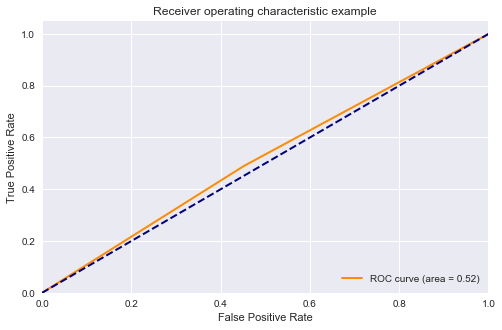

6 fitting Average KNN
内点:223  外点:153
总179
AUC值为0.5186406401125473


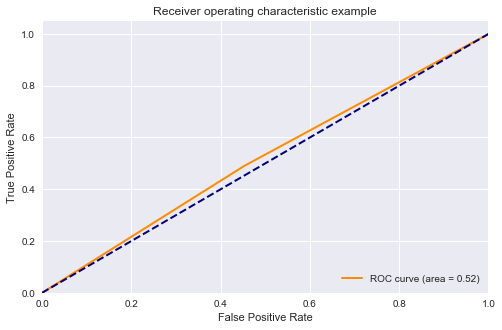

7 fitting Local Outlier Factor (LOF)
内点:216  外点:160
总184
AUC值为0.5060185185185185


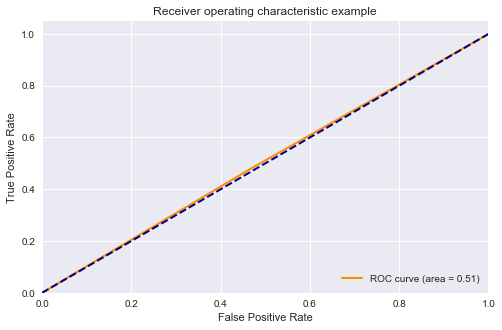

8 fitting Minimum Covariance Determinant (MCD)
内点:228  外点:148
总176
AUC值为0.5263157894736842


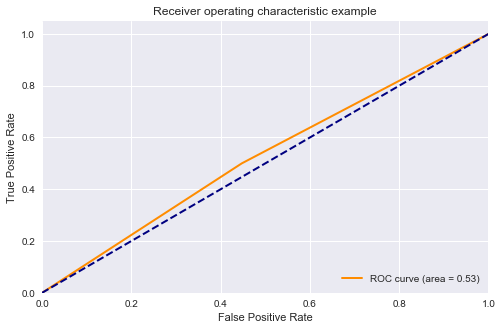

9 fitting One-class SVM (OCSVM)
内点:206  外点:170
总186
AUC值为0.5022844089091948


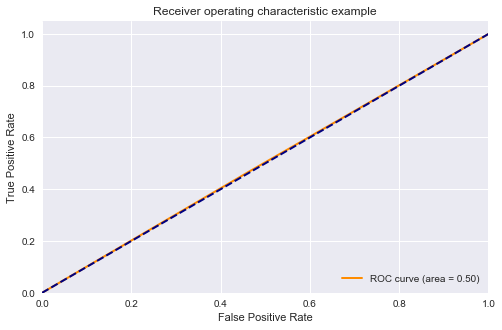

10 fitting Principal Component Analysis (PCA)
内点:217  外点:159
总193
AUC值为0.48133495638060464


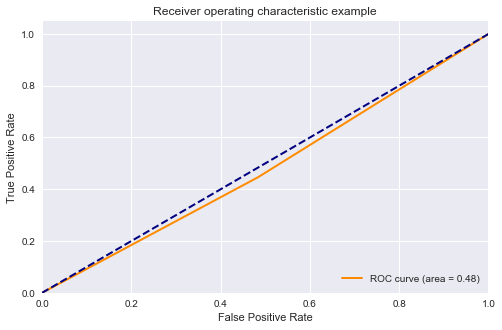

In [28]:
##########################################
###########划分训练集和测试集#############
##########################################
from sklearn.metrics import roc_curve, auc
algorithm_list=pd.DataFrame(columns=['CBLOF' ,'FB','HBOS','IF','AVG_KNN','Loc KNN','LOF','MCD','OCSVM','PCA'])

index = [i for i in range(len(abalone_data))] # 划分训练测试集
np.random.shuffle(index) # 打乱索引
abalone_data = abalone_data[index]
label=gt.values
abalone_data_train=abalone_data[0:int(len(abalone_data)*0.8),:]
abalone_data_test=abalone_data[int(len(abalone_data)*0.8)+1:len(abalone_data)-1,:]
label_test=label[int(len(abalone_data)*0.8)+1:len(abalone_data)-1,:]
temp=0
df_array=[]

for i, (clf_name, clf) in enumerate(classifiers.items()):
    print(i + 1, 'fitting', clf_name)
    # fit the data and tag outliers
    clf.fit(abalone_data_train)
    scores_pred = clf.decision_function(abalone_data_train) * -1
    y_pred = clf.predict(abalone_data_test)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    threshold = percentile(scores_pred, 100 * outliers_fraction)
    print("内点:"+str(n_inliers)+"  "+"外点:"+str(n_outliers))

    n_errors = (y_pred.flatten() != label_test.flatten()).sum()
    # plot the levels lines and the points
    print("总"+str(n_errors))
    fpr, tpr, threshold = roc_curve(y_pred, label_test.flatten())  ###计算真正率和假正率
    roc_auc = auc(fpr, tpr)  ###计算auc的值
    print("AUC值为"+str(roc_auc))
    df_array.append(roc_auc)

    lw = 2
    plt.figure(figsize=(8, 5))
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)  ###假正率为横坐标，真正率为纵坐标做曲线
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

algorithm_list.loc[temp]=df_array

In [29]:
#以列表的形式展出
algorithm_list.index=["abalone_benchmarks_0001.csv"]
algorithm_list.head()

,CBLOF,FB,HBOS,IF,AVG_KNN,Loc KNN,LOF,MCD,OCSVM,PCA
abalone_benchmarks_0001.csv,0.506673,0.503802,0.447676,0.482295,0.518917,0.518641,0.506019,0.526316,0.502284,0.481335


**分测试和训练集效果依然不行，AUC值徘徊在0.5左右，所以在正式所有cvs中仍采用全部数据集拟合的方式**